In [14]:
import pandas as pd
import numpy as np
from numpy import linalg
import emm
from emm.losses import *
from emm.reweighting import marginal

# Corpus
m = 5000
age = np.random.choice( ['0-18','18-30','30-40','40-60','60+'],
                        p=[  0.2,   0.25,   0.25,   0.2,   0.1], size=m)
sex = np.random.choice([0.0, 1.0], p=[0.5, 0.5], size=m)
height = np.random.normal(160, 15, size=m)

data = pd.DataFrame({"age": age, "sex": sex, "height": height})
dummies = pd.get_dummies(data['age'])
corpus = dummies
corpus['sex'] = data['sex']
corpus['height'] = data['height']


# Target
n = 1000



# Label 0
age_0 = np.random.choice( ['0-18','18-30','30-40','40-60','60+'],
                        p=[  0.05,   0.1,   0.25,   0.35,  0.25], size=n)
sex_0 = np.random.choice([0.0, 1.0], p=[0.6, 0.4], size=n)
height_0 = np.random.normal(170, 10, size=n)
outcome_0 = np.zeros(n)

# Label 1
age_1 = np.random.choice( ['0-18','18-30','30-40','40-60','60+'],
                        p=[  0.1,   0.1,   0.4,    0.25, 0.15], size=n)
sex_1 = np.random.choice([0.0, 1.0], p=[0.4, 0.6], size=n)
height_1 = np.random.normal(150, 10, size=n)
outcome_0 = np.ones(m)

age_bins = ['0-18','18-30','30-40','40-60','60+']
age_p_0 = [  0.05,   0.1,   0.25,   0.35,  0.25]
age_p_1 = [  0.1,   0.1,   0.4,    0.25, 0.15]
marginals = {0: [], 1:[]}
for count, ages in enumerate(age_bins):
    marginals[0] += [marginal(ages,'mean',EqualityLoss(age_p_0[count]))]
    marginals[1] += [marginal(ages,'mean',EqualityLoss(age_p_1[count]))]

marginals[0] += [emm.marginal('sex', 'mean', EqualityLoss(0.6))]
marginals[1] += [emm.marginal('sex', 'mean', EqualityLoss(0.4))]

marginals[0] += [marginal('height', 'mean', LeastSquaresLoss(170), standardize=True)]
marginals[0] += [marginal('height', 'var', LeastSquaresLoss(10**2), standardize=True)]

marginals[1] += [marginal('height', 'mean', LeastSquaresLoss(150), standardize=True)]
marginals[1] += [marginal('height', 'var', LeastSquaresLoss(10**2), standardize=True)]


regularizer = emm.EntropyRegularizer()
rwcs = emm.reweighting.generate_synth(corpus, marginals,regularizer=regularizer, lam=0.1, verbose=True)

print(emm.utils.weighted_mean(rwcs[rwcs['Outcome']==0].drop(columns=['Outcome', 'weights']), rwcs[rwcs['Outcome']==0]['weights']*2))
print(emm.utils.weighted_var(rwcs[rwcs['Outcome']==0]['height'],  rwcs[rwcs['Outcome']==0]['weights']*2)**(1/2))
print(emm.utils.weighted_mean(rwcs[rwcs['Outcome']==1].drop(columns=['Outcome', 'weights']), rwcs[rwcs['Outcome']==1]['weights']*2))
print(emm.utils.weighted_var(rwcs[rwcs['Outcome']==1]['height'],  rwcs[rwcs['Outcome']==1]['weights']*2)**(1/2))

CVX took 0.35421 seconds
CVX took 0.36821 seconds
0-18        0.050000
18-30       0.100000
30-40       0.250000
40-60       0.350000
60+         0.250000
sex         0.600000
height    169.524253
dtype: float64
10.284306701880979
0-18        0.100000
18-30       0.100000
30-40       0.400000
40-60       0.250000
60+         0.150000
sex         0.400000
height    150.435638
dtype: float64
10.314105699501944


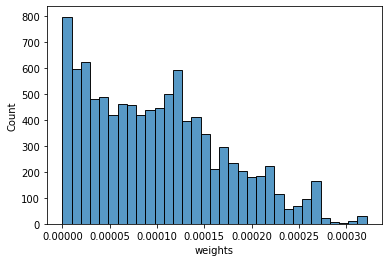

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(rwcs['weights'])
plt.show()

c:\users\branko\documents\git projects\emm\env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='height', ylabel='Density'>

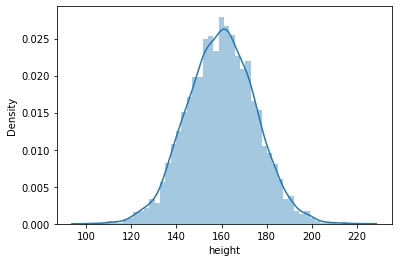

In [16]:
sns.distplot(rwcs[rwcs['Outcome']==0]['height'])